In [3]:
# from tensorflow.keras.applications import DenseNet121
import tensorflow as tf 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense , Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array , load_img
import matplotlib.pyplot as plt 
import numpy as np 
import cv2
import os 
import pandas as pd 
import pathlib

In [4]:
data_dir = pathlib.Path('./DataSet/Diverse_hand_gesture_dataset/train')

In [5]:
list_d = tf.data.Dataset.list_files(str(data_dir/'*.png') , shuffle=False)

In [6]:
image_count = tf.data.experimental.cardinality(list_d).numpy()
image_count

6400

In [7]:
for name in list_d.take(10):
    print(name.numpy())

b'DataSet\\Diverse_hand_gesture_dataset\\train\\1.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\10.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\100.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1000.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1001.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1002.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1003.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1004.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1005.png'
b'DataSet\\Diverse_hand_gesture_dataset\\train\\1006.png'


In [8]:
lbls = []

In [9]:
all_files = os.listdir('./DataSet/Diverse_hand_gesture_dataset/train')
txt_files = [f for f in all_files if f.endswith('.txt')]

In [10]:
len(all_files)

12800

In [11]:
txt_files.sort()
txt_files[100]

'11.txt'

In [12]:
for i in txt_files :
    path = './DataSet/Diverse_hand_gesture_dataset/train/{}'.format(i)
    _ , startX, startY, Width ,Height = pd.read_csv(path,sep=' ')
    lbls.append((float(startX[:8]) , float(startY[:8]) , float(Width[:8]) , float(Height[:8])))

In [13]:
lbls_data = tf.data.Dataset.from_tensor_slices(lbls)
dataset = tf.data.Dataset.zip((list_d,lbls_data))

In [14]:
for i in dataset.take(2):
    p,l = i
    print(p , l)

tf.Tensor(b'DataSet\\Diverse_hand_gesture_dataset\\train\\1.png', shape=(), dtype=string) tf.Tensor([0.511161 0.5625   0.245536 0.3125  ], shape=(4,), dtype=float32)
tf.Tensor(b'DataSet\\Diverse_hand_gesture_dataset\\train\\10.png', shape=(), dtype=string) tf.Tensor([0.386161 0.537946 0.28125  0.290179], shape=(4,), dtype=float32)


In [15]:
dataset = dataset.shuffle(image_count , reshuffle_each_iteration=False)

In [16]:
val_size = int (image_count * 0.1)
train_data = dataset.skip(val_size)
validation_data = dataset.take(val_size)

In [17]:
def decode_img (img) :
    img = tf.io.decode_png(img,channels=3)
    return tf.image.resize(img,[224,224])

In [18]:
def process_path(file_path ,labels):
    img = tf.io.read_file(file_path)
    img = decode_img(img) / 255.0
    return img , labels

In [19]:
train_data = train_data.map(process_path,num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.map(process_path,num_parallel_calls=tf.data.AUTOTUNE)


train_data = train_data.batch(64)
validation_data = validation_data.batch(64)


train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE)

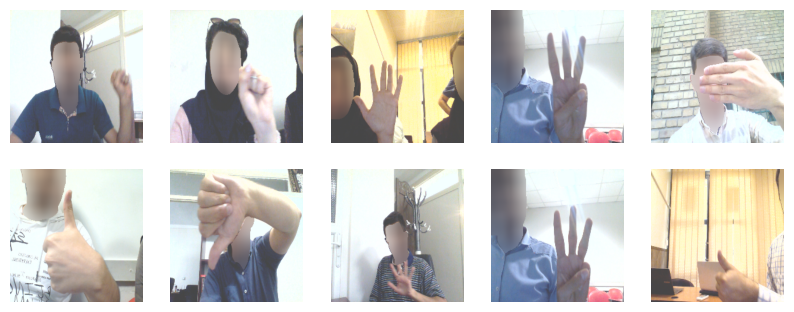

In [20]:
image_batch , label_batch = next(iter(train_data))

plt.figure(figsize=(10,10))
for i in range(10) :
    ax = plt.subplot(5,5,i+1)
    plt.imshow((image_batch[i].numpy()*255).astype('uint8'))
    plt.axis("Off")

In [21]:
# denseNet121 = DenseNet121(weights='./models/densenet121_weights_tf_dim_ordering_tf_kernels.h5' , input_shape=(224,224,3))
vgg = VGG16(weights='./models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',include_top=False , input_shape=(224,224,3))  

In [22]:
# denseNet121.trainable = False
vgg.trainable = False

In [23]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(4,activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 17936548 (68.42 MB)
Trainable params: 3221

In [24]:
opt = Adam(learning_rate=1e-4)
model.compile(loss="mse",optimizer=opt)

In [25]:
from keras.callbacks import ReduceLROnPlateau

reducelr = ReduceLROnPlateau('loss' , 0.1 ,2,min_lr=1e-6)

In [26]:
history = model.fit(
    train_data,
    validation_data= validation_data,
    epochs = 10,
    callbacks = [reducelr]
)

Epoch 1/10

90/90 [==============================] - 559s 6s/step - loss: 0.0088 - val_loss: 0.0054 - lr: 1.0000e-04
Epoch 2/10
90/90 [==============================] - 514s 6s/step - loss: 0.0030 - val_loss: 0.0033 - lr: 1.0000e-04
Epoch 3/10
90/90 [==============================] - 534s 6s/step - loss: 0.0019 - val_loss: 0.0026 - lr: 1.0000e-04
Epoch 4/10
90/90 [==============================] - 508s 6s/step - loss: 0.0013 - val_loss: 0.0022 - lr: 1.0000e-04
Epoch 5/10
90/90 [==============================] - 478s 5s/step - loss: 0.0010 - val_loss: 0.0022 - lr: 1.0000e-04
Epoch 6/10
90/90 [==============================] - 627s 5s/step - loss: 8.6687e-04 - val_loss: 0.0021 - lr: 1.0000e-04
Epoch 7/10
90/90 [==============================] - 481s 5s/step - loss: 7.5193e-04 - val_loss: 0.0021 - lr: 1.0000e-04
Epoch 8/10
90/90 [==============================] - 625s 7s/step - loss: 6.8600e-04 - val_loss: 0.0020 - lr: 1.0000e-04
Epoch 9/10
90/90 [==============================] - 1404s 1

In [ ]:
def draw_bbox( img , box ):
    image = np.copy(img)
    (h,w) = image.shape[:2]
    
    (X , Y , dX , dY) = box[0]
    
    
    X = X*w
    Y = Y*h
    
    dX = dX * w
    dY = dY * h
    
    startX =int( X - dX/2 )
    startY =int( Y - dY/2 )
    
    endX = int ( X + dX/2 )
    endY = int ( Y + dY/2 )
    

    
    cv2.rectangle(image, (startX , startY) , (endX , endY) ,(0,0,0) ,2)
    
    return image

In [32]:
sample_num = int(input("Enter a Number for prediction :"))
test_path = './DataSet/Diverse_hand_gesture_dataset/test/like/{}.png'.format(sample_num)
print("Path is : ", test_path)

Path is :  ./DataSet/Diverse_hand_gesture_dataset/test/like/10626.png


1/1 [==============================] - 0s 128ms/step


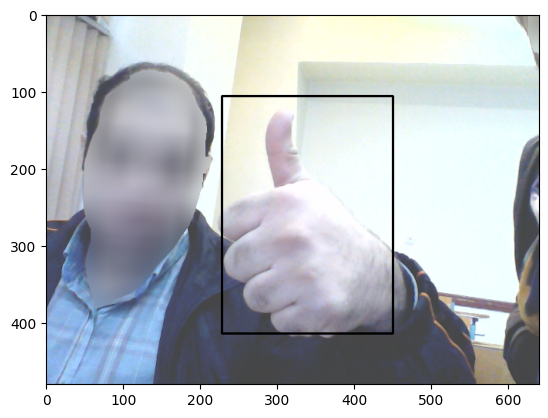

In [33]:
image = load_img(test_path ,target_size=(224,224))
image_show = plt.imread(test_path)
image = img_to_array(image) / 255.0
image = np.expand_dims(image,axis=0)
box = model.predict(image)
img = draw_bbox(image_show , box)
plt.imshow(img)  